# HadISST Data Set

In [1]:
from datetime import date, datetime, timedelta

import cdlib
import cdlib.algorithms
import cdlib.viz
import joblib
import netCDF4 as nc
import numpy as np
import scipy.signal
import networkx as nx
import cartopy.crs as ccrs
import matplotlib as mpl
from matplotlib import pyplot as plt
from tqdm import tqdm

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw'}


In [2]:
np.seterr(over="raise", under="raise")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
SST_ICE_VAL = -1000
MAX_LATITUDE = 80
MIN_LATITUDE = -50
DOWNSAMPLE_DEGREES = 5
CORRELATION_THRESHOLD = 0.4

## Loading the dataset
I am using the sea surface temperature data from the Hadley Center Sea Surface Temperature data set (HadISST) available here:
https://www.metoffice.gov.uk/hadobs/hadisst/index.html

I downloaded the data in NetCDF format from here:
https://www.metoffice.gov.uk/hadobs/hadisst/data/download.html

In [4]:
ds = nc.Dataset("../data/01_raw/HadISST_sst.nc")
print(ds)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Title: Monthly version of HadISST sea surface temperature component
    description: HadISST 1.1 monthly average sea surface temperature
    institution: Met Office Hadley Centre
    source: HadISST
    reference: Rayner, N. A., Parker, D. E., Horton, E. B., Folland, C. K., Alexander, L. V., Rowell, D. P., Kent, E. C., Kaplan, A.  Global analyses of sea surface temperature, sea ice, and night marine air temperature since the late nineteenth century J. Geophys. Res.Vol. 108, No. D14, 4407 10.1029/2002JD002670
    Conventions: CF-1.0
    history: 21/3/2022 converted to netcdf from pp format
    supplementary_information: Updates and supplementary information will be available from http://www.metoffice.gov.uk/hadobs/hadisst
    comment: Data restrictions: for academic research use only. Data are Crown copyright see (http://www.opsi.gov.uk/advice/crown-copyright/copyright-guidance/index.htm

In [5]:
first_date = date(1870, 1, 1)
last_date = first_date + timedelta(days=ds["time_bnds"][-1, 1].item())
print(f"Data covers {first_date} to {last_date}")

Data covers 1870-01-01 to 2022-02-01


In [6]:
sst_expanded = ds["sst"][...]
is_ice = (sst_expanded == SST_ICE_VAL).filled(False)  # 100% sea-ice
min_temp = np.nanmin(sst_expanded[~is_ice])
max_temp = np.nanmax(sst_expanded[~is_ice])

print(f"Temperature range: {min_temp:.2g}°C to {max_temp:.2g}°C")

Temperature range: -1.8°C to 35°C


## Geographical plots
We can plot the sea surface temperature data for a given month as a contour plot. We use the same colours for temperatures across all time points.

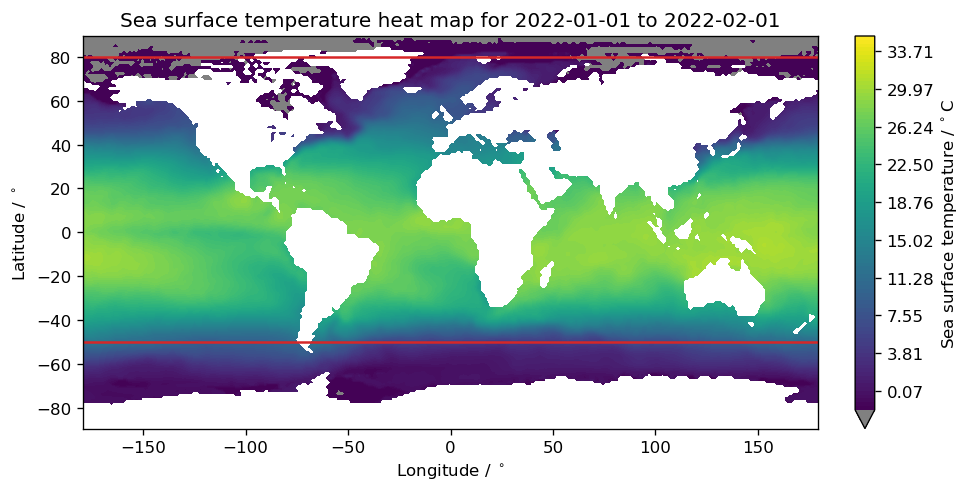

In [7]:
t_ix = -1  # Time index (i.e. choose month to plot)

fig, ax = plt.subplots(figsize=(8, 4), dpi=120, constrained_layout=True)

cmap = mpl.cm.get_cmap("viridis").with_extremes(under="gray")
h = ax.contourf(
    np.asarray(ds["longitude"]),
    np.asarray(ds["latitude"]),
    ds["sst"][t_ix].filled(np.nan),
    levels=np.linspace(min_temp-1e-6, max_temp+1e-6, 100),
    vmin=min_temp,
    vmax=max_temp,
    cmap=cmap,
    extend="min",
)
fig.colorbar(h, label="Sea surface temperature / $^\\circ\\mathrm{C}$")

ax.axhline(MAX_LATITUDE, color="tab:red")
ax.axhline(MIN_LATITUDE, color="tab:red")

ax.set_xlabel("Longitude / $^\\circ$")
ax.set_ylabel("Latitude / $^\\circ$")
ax.set_title(
    "Sea surface temperature heat map for {} to {}".format(
        first_date + timedelta(days=ds["time_bnds"][t_ix, 0].item()),
        first_date + timedelta(days=ds["time_bnds"][t_ix, 1].item())
    )
);

## Time-series plots

In [8]:
ix_lat, ix_long = 41, 174
print("Coordinates:", (float(ds["latitude"][ix_lat])), float(ds["longitude"][ix_long]))

Coordinates: 48.5 -5.5


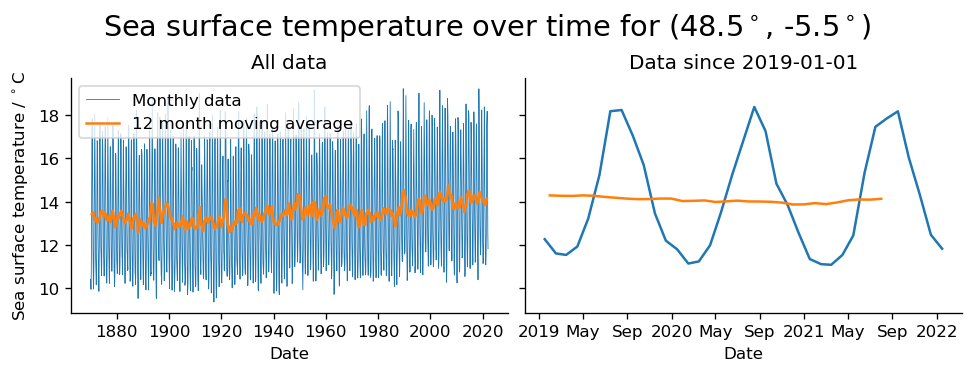

In [9]:
def to_numpy_datetimes(offset_days, first_date):
    return np.datetime64(first_date) + offset_days.astype("timedelta64[D]")

def moving_av(x, width):
    return np.convolve(x, np.ones(width), "valid") / width

def plot_sst_ts(
    ds, sst, ix_lat, ix_long, sst_smooth=None, sst_smooth_name=None, title=None
):
    t = to_numpy_datetimes(ds["time"][:], first_date)
    sst_ = sst[:, ix_lat, ix_long]
    
    if sst_smooth is not None:
        t_av = t
        sst_av = sst_smooth[:, ix_lat, ix_long]
        if sst_smooth_name is None:
            sst_smooth_name = "Smoothed"
    else:
        t_av = to_numpy_datetimes(moving_av(ds["time"][:], 12), first_date)
        sst_av = moving_av(sst_, 12)
        if sst_smooth_name is None:
            sst_smooth_name = "12 month moving average"

    fig, axs = plt.subplots(
        1, 2,
        sharey=True,
        figsize=(8, 3), dpi=120,
        constrained_layout=True,
    )

    axs[0].plot(t, sst_, linewidth=0.5, label="Monthly data")
    axs[0].plot(t_av, sst_av, label=sst_smooth_name)
    axs[0].legend()

    cutoff = date(2019, 1, 1)
    axs[1].plot(t[t >= cutoff], sst_[t >= cutoff], label="Monthly data")
    axs[1].plot(
        t_av[t_av >= cutoff], sst_av[t_av >= cutoff], label=sst_smooth_name
    )

    for ax in axs:
        locator = mpl.dates.AutoDateLocator()
        formatter = mpl.dates.ConciseDateFormatter(locator)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)

        ax.spines[["top", "right"]].set_visible(False)

    for ax in axs:
        ax.set_xlabel("Date")
    axs[0].set_ylabel("Sea surface temperature / $^\\circ\\mathrm{C}$")
    axs[0].set_title("All data")
    axs[1].set_title(f"Data since {cutoff}")
    
    if not title:
        title = "Sea surface temperature over time"
    fig.suptitle(
        f"{title} for ({float(ds['latitude'][ix_lat])}$^\\circ$, {float(ds['longitude'][ix_long])}$^\\circ$)",
        fontsize="xx-large",
    )


plot_sst_ts(ds, ds["sst"][:], ix_lat, ix_long);

# Anomaly time series
To generate our so-called anomaly time series, we:
  - Remove a linear trend from all time series
  - Remove the annual seasonality from all time series
  - Apply a low-pass Butterworth filter with a cutoff frequency of 1/13 per month and order 8 (there is no out-of-the-box Lanczos filter in scipy)

In [10]:
def detrend(t, y):
    """Remove a linear trend from masked data"""
    assert y.ndim == 3
    
    has_masked_values = y.mask.any(axis=0)
    all_masked_values = y.mask.all(axis=0)
    
    y_detrend = y.copy()
    
    # First handle most of the locations together (the ones without masked
    # values). We don't do everything in the for loop since this is slow.
    t_mat = np.stack([t, np.ones_like(t)], axis=-1)
    t_mat = _unmask_safe(t_mat)
    y_not_masked = _unmask_safe(y[:, ~has_masked_values])
    beta, _, _, _ = np.linalg.lstsq(t_mat, y_not_masked, rcond=None)
    
    y_detrend[:, ~has_masked_values] -= t_mat @ beta
    
    # Then handle the ones with masked values
    # NOTE: I am now no longer calling this with partially masked series
    if (has_masked_values & ~all_masked_values).any():
        for i, j in tqdm(np.argwhere(has_masked_values & ~all_masked_values)):
            mask = y[:, i, j].mask
            t_ = t[~mask]
            y_ = y[~mask, i, j]
            t_mat = np.stack([t_, np.ones_like(t_)], axis=-1)
            beta, _, _, _ = np.linalg.lstsq(t_mat, y_, rcond=None)
            y_detrend[~mask, i, j] -= t_mat @ beta
    
    return y_detrend


def _unmask_safe(arr):
    if np.ma.is_masked(arr):
        raise ValueError("arr has masked values!")
    return arr.filled()  # Fill value doesn't matter since not masked

    
def remove_seasonal(y):
    """Remove annual seasonality from masked data"""
    n_pts = len(y)
    y_bymonth = [[] for _ in range(12)]
    for i in range(n_pts):
        y_bymonth[i % 12].append(y[i])
    seas_avg = [sum(y_) / len(y_) for y_ in y_bymonth]
        
    y_noseas = y.copy()
    for i in range(n_pts):
        y_noseas[i] -= seas_avg[i%12]
    
    return y_noseas


def butter_lowpass_filter(y, cutoff, sample_freq, order, axis=-1):
    """Implement a butterworth filter"""
    sos = scipy.signal.butter(order, cutoff, fs=sample_freq, output="sos")
    y_filt = scipy.signal.sosfiltfilt(sos, y, axis=axis)
    return y_filt

In [11]:
print("Removing values which have ever had ice")
# I remove values which have ever had ice since the "missing data" causes
# problems both in the pre-processing, and in correlating pairs of time-series.
ever_ice = is_ice.any(axis=0)
sst_masked = np.ma.masked_where(
    *np.broadcast_arrays(ever_ice, sst_expanded, subok=True)
)

print("Detrending")
sst_detrend = detrend(ds["time"][:], sst_masked)

print("Removing seasonal components")
sst_noseas = remove_seasonal(sst_detrend)

print("Applying low pass filter")
# I'm using a Butterworth filter since the Lanczos filter isn't implemented in
# scipy out-of-the-box
mask = sst_noseas.mask.any(axis=0)
sst_filt = sst_noseas.copy()
sst_filt[:, ~mask] = butter_lowpass_filter(
    sst_noseas[:, ~mask].filled(), cutoff=1/13, sample_freq=1, order=8, axis=0
)

# TODO: Delete this bit?
# print("Replacing sea ice values")
# sst_filt[is_ice] = SST_ICE_VAL

print("Done")

Removing values which have ever had ice
Detrending
Removing seasonal components
Applying low pass filter
Done


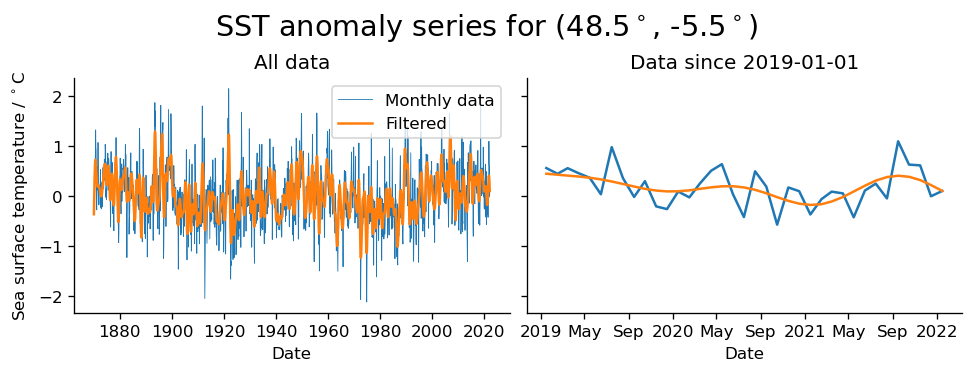

In [12]:
plot_sst_ts(ds, sst_noseas, ix_lat, ix_long, sst_smooth=sst_filt, sst_smooth_name="Filtered", title="SST anomaly series")

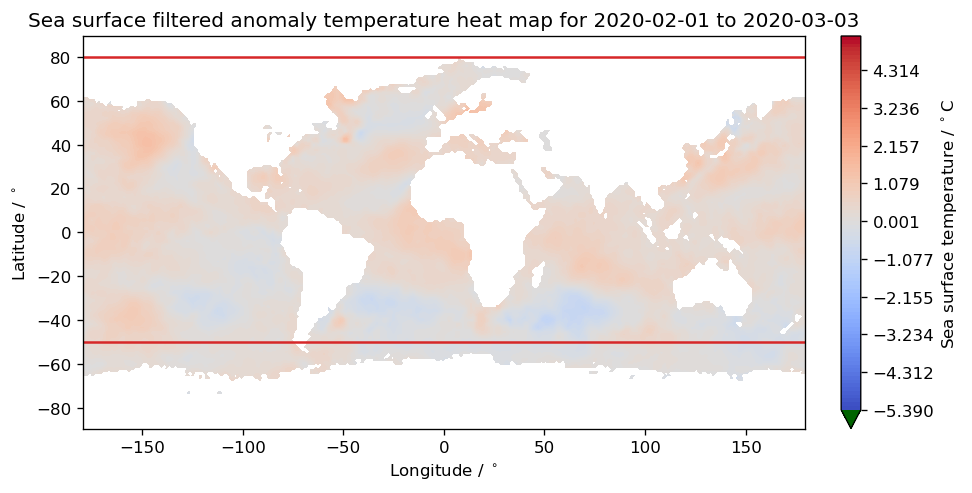

In [13]:
_t_ix = -24
_sst = sst_filt.copy()

_min_temp = _sst.min()
_max_temp = _sst.max()

fig, ax = plt.subplots(figsize=(8, 4), dpi=120, constrained_layout=True)

cmap = mpl.cm.get_cmap("coolwarm").with_extremes(under="darkgreen")
h = ax.contourf(
    ds["longitude"][:].filled(),
    ds["latitude"][:].filled(),
    _sst[_t_ix].filled(np.nan),
    levels=np.linspace(_min_temp-1e-6, _max_temp+1e-6, 100),
    vmin=_min_temp,
    vmax=_max_temp,
    cmap=cmap,
    extend="min",
)
fig.colorbar(h, label="Sea surface temperature / $^\\circ\\mathrm{C}$")

ax.axhline(MAX_LATITUDE, color="tab:red")
ax.axhline(MIN_LATITUDE, color="tab:red")

ax.set_xlabel("Longitude / $^\\circ$")
ax.set_ylabel("Latitude / $^\\circ$")
ax.set_title(
    "Sea surface filtered anomaly temperature heat map for {} to {}".format(
        first_date + timedelta(days=ds["time_bnds"][_t_ix, 0].item()),
        first_date + timedelta(days=ds["time_bnds"][_t_ix, 1].item())
    )
);

# Generating a network
**TODO:** Resample so that points at the poles are not overrepresented?

Each gridpoint is one node in the network. We need to calculate correlations between the anomaly time series and add edges where these exceed some threshold.
Unlike in the Tantet paper, I also include negative correlations which exceed the threshold.

Points outside the latitude range are discarded in line with the Tantet 2014 paper, since the data sampling quality there is poor.

In [14]:
latitude = ds["latitude"][:].filled()
longitude = ds["longitude"][:].filled()

latitude_mask = (latitude >= MIN_LATITUDE) & (latitude <= MAX_LATITUDE)
sst_filt_downsample = sst_filt[
    (
        slice(None),
        *np.ix_(
            (latitude_mask & (latitude % DOWNSAMPLE_DEGREES == 0.5)),
            (longitude % DOWNSAMPLE_DEGREES == 0.5),
        )
    )
]
lat_downsample = latitude[(latitude_mask & (latitude % DOWNSAMPLE_DEGREES == 0.5))]
long_downsample = longitude[(longitude % DOWNSAMPLE_DEGREES == 0.5)]

In [15]:
def compute_correlation(y):
    """ Compute the Pearson correlation between all columns at lag 0
    
    Warning:
        NaN is returned when one of the time-series is constant.
    """
    y_centered = y - y.mean(axis=0)
    y_std = np.sqrt(np.mean(y_centered**2, axis=0))
    n_time, n_space = y.shape
    
    # Old code to run in serial with progress bar
    # cov = np.zeros((n_space, n_space))
    # for i in tqdm(range(n_space), desc="Computing covariances"):
    #     cov[i] = np.mean(y.T * y.T[i], axis=-1)
    
    # New code to run in parallel with joblib
    def compute_cov(x, y):
        return np.mean(x * y, axis=-1)
    
    print(f"Total number of tasks: {n_space}")
    cov = joblib.Parallel(n_jobs=-1, prefer="threads", verbose=1, max_nbytes="110M")(
        joblib.delayed(compute_cov)(y.T, y.T[i])
        for i in range(n_space)
    )
    cov = np.array(cov)
    r = cov / np.outer(y_std, y_std)
    
    # We clip the result for numerical stability. The correlation can be slightly
    # greater than 1 before doing this thanks to numerical instability.
    return np.clip(r, -1, 1)

In [16]:
def safe_remove_masked_timeseries(lat, long, y):
    """Convert a 3D masked array to 2D regular array by removing masked values
    
    The time dimension is assume to be the first dimension. It is asserted that
    either all or none of a given time-series is masked.
    """
    assert (y.mask.any(axis=0) == y.mask.all(axis=0)).all()
    mask = y.mask.any(axis=0)
    
    y_unmask = y[:, ~mask].filled(np.nan)
    assert not np.isnan(y_unmask).any()
    
    ix_lat, ix_long = np.nonzero(~mask)
    lat_unmask = lat[ix_lat]
    long_unmask = long[ix_long]
    
    return lat_unmask, long_unmask, y_unmask

In [17]:
%%time
lat_reshape, long_reshape, sst_filt_reshape = safe_remove_masked_timeseries(
    lat_downsample, long_downsample, sst_filt_downsample
)
# We have to change from float32 to float64 to avoid overflow errors
sst_corr_reshape = compute_correlation(sst_filt_reshape.astype("float"))

Total number of tasks: 1198


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    2.6s


CPU times: user 42.8 s, sys: 511 ms, total: 43.3 s
Wall time: 3.93 s


[Parallel(n_jobs=-1)]: Done 1198 out of 1198 | elapsed:    3.9s finished


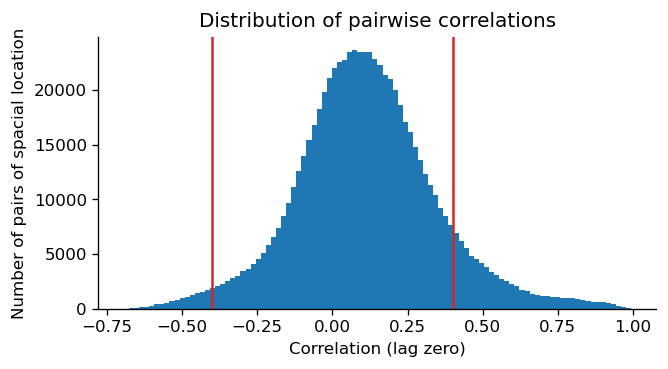

In [18]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=120)
ax.hist(sst_corr_reshape[np.triu_indices(sst_corr_reshape.shape[0], k=1)], bins=100)
ax.axvline(CORRELATION_THRESHOLD, color="tab:red")
ax.axvline(-CORRELATION_THRESHOLD, color="tab:red")
ax.spines[["top", "right"]].set_visible(False)
ax.set_xlabel("Correlation (lag zero)")
ax.set_ylabel("Number of pairs of spacial location")
ax.set_title("Distribution of pairwise correlations");

In [19]:
adj_mat = np.abs(sst_corr_reshape) >= CORRELATION_THRESHOLD
# adj_mat = sst_corr_reshape >= CORRELATION_THRESHOLD
np.fill_diagonal(adj_mat, 0)
graph = nx.from_numpy_array(adj_mat)
nx.set_node_attributes(graph, {i: x for i, x in enumerate(lat_reshape)}, "latitude")
nx.set_node_attributes(graph, {i: x for i, x in enumerate(long_reshape)}, "longitude")

print(f"Number of nodes: {graph.number_of_nodes():,}")
print(f"Number of edges: {graph.number_of_edges():,}")

Number of nodes: 1,198
Number of edges: 84,514


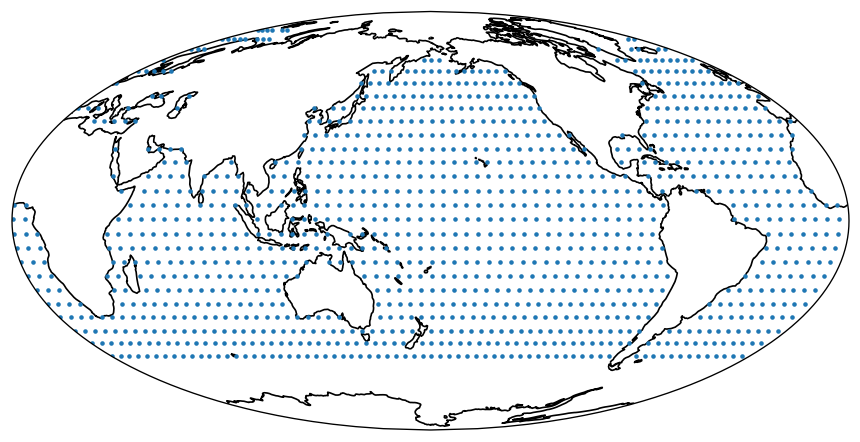

In [20]:
fig = plt.figure(figsize=(9, 6), dpi=120)
ax = fig.add_subplot(projection=ccrs.Mollweide(central_longitude=180))
ax.coastlines()
ax.set_global()

nodes = list(graph.nodes)
ax.scatter(
    [graph.nodes[n]["longitude"] for n in nodes],
    [graph.nodes[n]["latitude"] for n in nodes],
    s=3,  # Use s=1 when plotting resolution of 2 degrees or smaller
    transform=ccrs.PlateCarree(),
)
# WARNING: Even with alpha=0.05, plotting edges creates a mess (and takes AGES!)
# for j, edge in enumerate(graph.edges()):
#     lat = [graph.nodes[i]["latitude"] for i in edge]
#     long = [graph.nodes[i]["longitude"] for i in edge]
#     ax.plot(long, lat, transform=ccrs.Geodetic(), color="red", alpha=0.05)

None

In [21]:
import pickle
with open("../data/02_intermediates/graph.pkl", "wb") as f:
    pickle.dump(graph, f)

# Community detection
First we define a function to visualize the communities we discover.

In [22]:
def _singleton(l):
    [x] = l
    return x


def plot_communities(
    graph, communities, algorithm_title=None, central_longitudes=None,
    dpi=100, cmap=None, max_communities=float("Inf"),
):
    if not central_longitudes:
        central_longitudes = [180, 0]

    # Set up axes
    fig = plt.figure(figsize=(9, 6), dpi=dpi, constrained_layout=True)
    gs = fig.add_gridspec(len(central_longitudes), 1)
    
    axs = np.empty(gs.get_geometry(), dtype="object")
    for i in range(axs.shape[0]):
        for j in range(axs.shape[1]):
            proj = ccrs.Mollweide(
                central_longitude=central_longitudes[i * axs.shape[1] + j],
            )
            ax = fig.add_subplot(gs[i, j], projection=proj)
            ax.coastlines()
            ax.set_global()
            axs[i, j] = ax

    # Plot communities
    if communities != sorted(communities, key=len, reverse=True):
        raise ValueError(
            "Expected communities to be sorted in decreasing order of size!"
        )
    if len(communities) > max_communities:
        tail_community = set().union(*[c for c in communities[max_communities-1:]])
        communities = communities[:max_communities-1] + [tail_community]
    
    community_membership = {
        n: _singleton([i for i, c in enumerate(communities) if n in c])
        for n in graph.nodes
    }
    
    if cmap is None:
        if len(communities) <= 10:
            cmap = mpl.cm.get_cmap("tab10", len(communities))
        elif len(communities) <= 20:
            cmap = mpl.cm.get_cmap("tab20", len(communities))
        else:
            cmap = mpl.cm.get_cmap("gist_ncar", len(communities))
    elif isinstance(cmap, str):
        cmap = mpl.cm.get_cmap(cmap, len(communities))
    
    norm = mpl.colors.BoundaryNorm(np.arange(-0.5, len(communities)), cmap.N)

    nodes = list(graph.nodes)
    for ax in axs.flat:
        h = ax.scatter(
            [graph.nodes[n]["longitude"] for n in nodes],
            [graph.nodes[n]["latitude"] for n in nodes],
            s=10,  # Use s=1 for 2 degree resolution
            c=[community_membership[n] for n in nodes],
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            norm=norm,
        )

    cbar = fig.colorbar(
        h,
        label="Community: index (size)",
        ticks=np.arange(len(communities)),
        ax=axs.ravel().tolist(),
    )
    cbar.ax.set_yticklabels(
        [f"{i} ({len(communities[i])})" for i in range(len(communities))]
    )
    
    title = "Community assignment"
    if algorithm_title:
        if len(algorithm_title) < 16:
            title += f" from {algorithm_title}"
        else:
            title += f" from\n {algorithm_title}"
    axs[0, 0].set_title(title, fontsize="xx-large")
    
    return fig

## Newman-Girvan multiscale modularity community detection (via networkx)

In [23]:
%%time
resolution = 1.25
communities = nx.community.greedy_modularity_communities(graph, resolution=resolution)
print(f"Found {len(communities)} communities")

Found 11 communities
CPU times: user 6.57 s, sys: 23.2 ms, total: 6.6 s
Wall time: 6.6 s


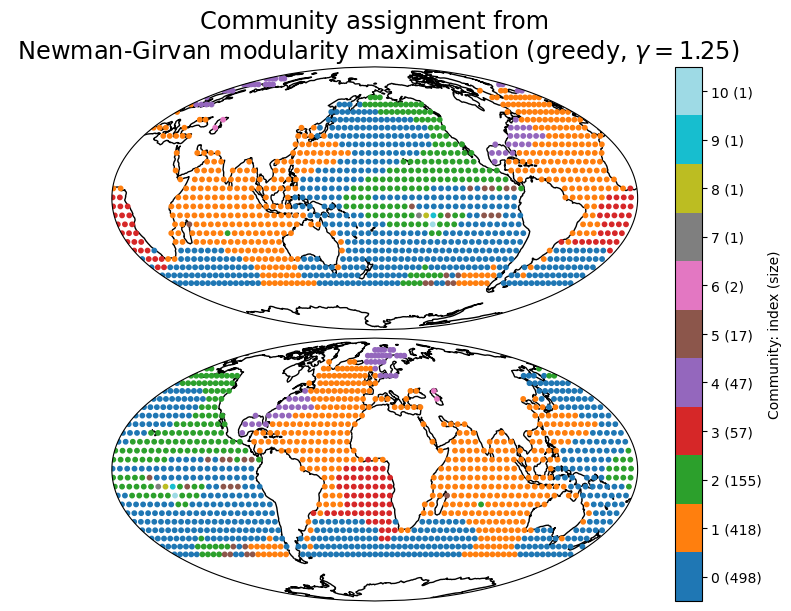

In [24]:
plot_communities(
    graph,
    communities,
    algorithm_title=f"Newman-Girvan modularity maximisation (greedy, $\\gamma = {resolution}$)"
);

In [25]:
%%time
resolution = 0.7
communities = nx.community.louvain_communities(graph, resolution=resolution)
communities = sorted(communities, key=len, reverse=True)
print(f"Found {len(communities)} communities")

Found 5 communities
CPU times: user 865 ms, sys: 0 ns, total: 865 ms
Wall time: 863 ms


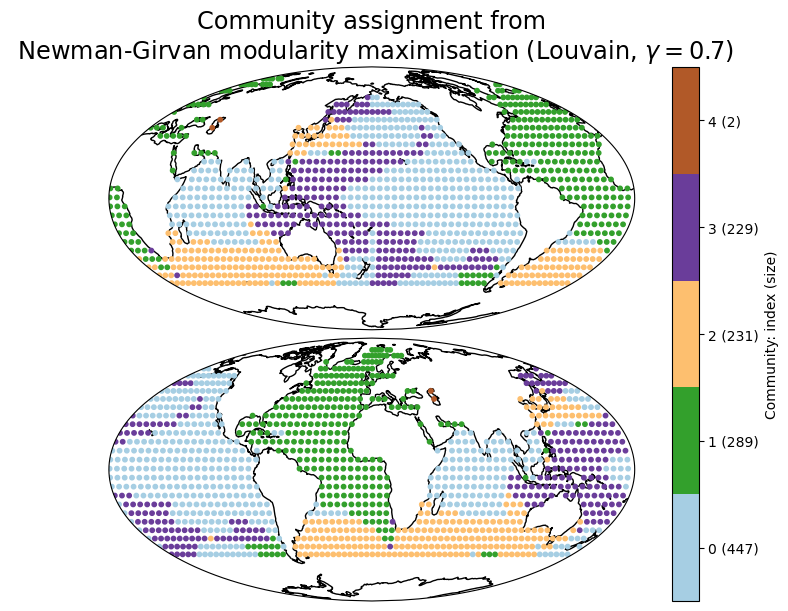

In [26]:
plot_communities(
    graph,
    communities,
    algorithm_title=f"Newman-Girvan modularity maximisation (Louvain, $\\gamma = {resolution}$)",
    cmap="Paired",
);

## Infomap (via CDlib)

In [27]:
%%time
comms = cdlib.algorithms.infomap(graph)

CPU times: user 1.01 s, sys: 11.8 ms, total: 1.03 s
Wall time: 460 ms


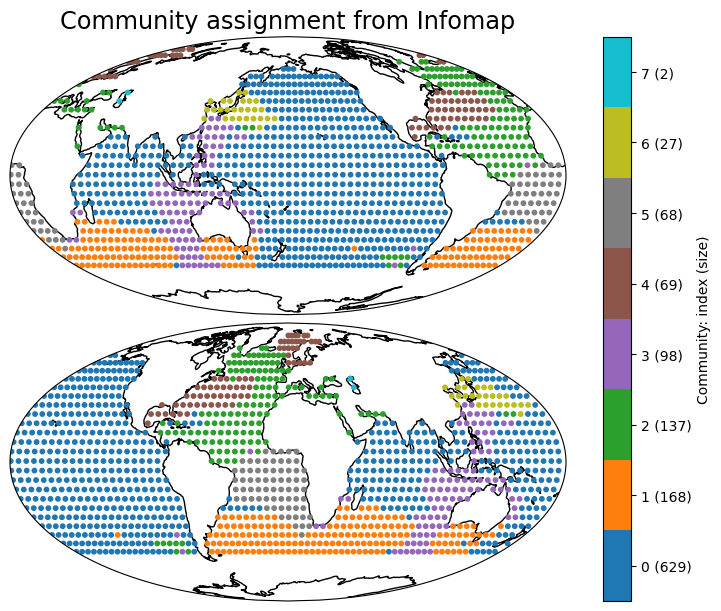

In [28]:
plot_communities(graph, comms.communities, algorithm_title="Infomap");

## Surprise
The surprise algorithm is a probabilistic algorithm which seems to work reasonably well: it is fast to run and picks up the ENSO community.

It can also handle weighted edges (if I use correlation as a weight) and node sizes (so I can downweight nodes nearer the poles).

In [29]:
%%time
comms = cdlib.algorithms.surprise_communities(graph)
print(f"Found {len(comms.communities)} communities")

Found 32 communities
CPU times: user 624 ms, sys: 1.18 ms, total: 625 ms
Wall time: 628 ms


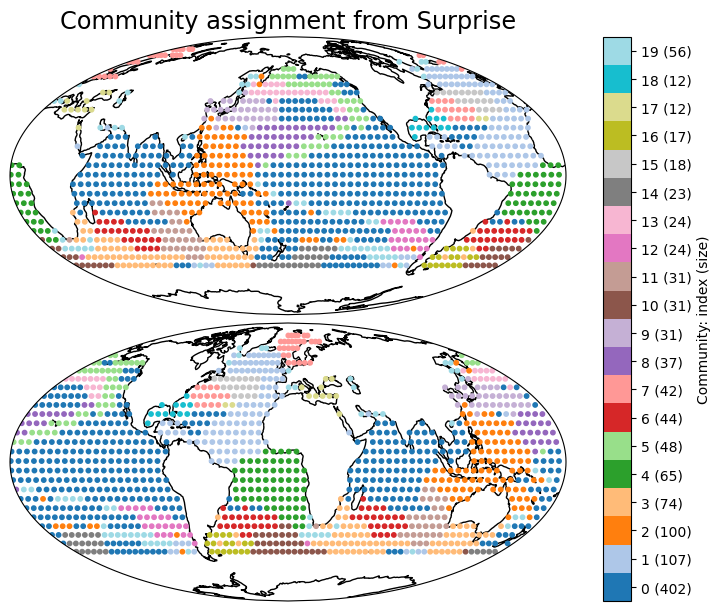

In [30]:
plot_communities(graph, comms.communities, algorithm_title="Surprise", max_communities=20);